In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches

import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from io import StringIO # Python3 use: from io import StringIO
import sys
#from utils.computation import * 
#from utils.diagnostics import * 
%matplotlib notebook
np.set_printoptions(formatter={'float': lambda x: "{0:5.3f}".format(x)})

to do : 
    1. test more functions
    2. try one-step line search
    3. plot grid of convergence
    
    ** refactor the code of library

# Visualisation tool

# tested objective function

In [19]:
def bukin(x):
    '''
    non-disappearing gradient
    optimum: 0
    optimal: (-10, 1)
    '''
    return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2)) + 0.01 * np.abs(x[0] + 10)
def bukin_first(x):
    return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0]**2))
def bukin_second(x):
    return 0.01 * np.abs(x[0] + 10)
def bukin_noabs(x):
    return 100 * (x[1] - 0.01 * x[0]**2)


In [20]:
f = lambda x: 0.01 * x**2
x = np.linspace(-50, 50, 201)
y = f(x)

In [25]:
x[120]

10.0

In [26]:
bukin_first((x[120], y[120]))

0.0

In [27]:
bukin((x,y))

array([0.400, 0.395, 0.390, 0.385, 0.380, 0.375, 0.370, 0.365, 0.360,
       0.355, 0.350, 0.345, 0.340, 0.335, 0.330, 0.325, 0.320, 0.315,
       0.310, 0.305, 0.300, 0.295, 0.290, 0.285, 0.280, 0.275, 0.270,
       0.265, 0.260, 0.255, 0.250, 0.245, 0.240, 0.235, 0.230, 0.225,
       0.220, 0.215, 0.210, 0.205, 0.200, 0.195, 0.190, 0.185, 0.180,
       0.175, 0.170, 0.165, 0.160, 0.155, 0.150, 0.145, 0.140, 0.135,
       0.130, 0.125, 0.120, 0.115, 0.110, 0.105, 0.100, 0.095, 0.090,
       0.085, 0.080, 0.075, 0.070, 0.065, 0.060, 0.055, 0.050, 0.045,
       0.040, 0.035, 0.030, 0.025, 0.020, 0.015, 0.010, 0.005, 0.000,
       0.005, 0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045,
       0.050, 0.055, 0.060, 0.065, 0.070, 0.075, 0.080, 0.085, 0.090,
       0.095, 0.100, 0.105, 0.110, 0.115, 0.120, 0.125, 0.130, 0.135,
       0.140, 0.145, 0.150, 0.155, 0.160, 0.165, 0.170, 0.175, 0.180,
       0.185, 0.190, 0.195, 0.200, 0.205, 0.210, 0.215, 0.220, 0.225,
       0.230, 0.235,

<IPython.core.display.Javascript object>


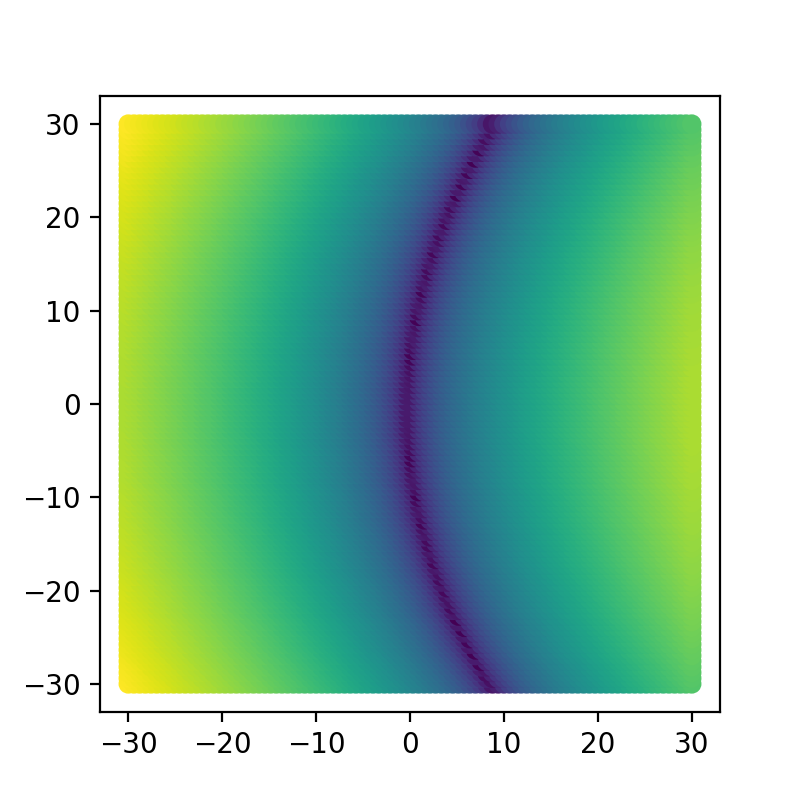

In [4]:
N = 100
lim = 30
plot_scatter(bukin, lim, N)

In [5]:
plot_surface(bukin, lim, N*2)

In [6]:
plot_surface(bukin_first, lim, N)

In [32]:
plot_surface(bukin_second, lim, N)

In [21]:
def cma_es_general(mean0, D, alpha, beta, adjust, func, dfunc):
    '''
    @param mean0: initial mean of groups of points
    @param D: sqrt of eigenvalues of initial variance of points
    @param alpha: initial step size
    @param beta: control the armijo condition
    @return snapshot_val: snapshot of func values of points every 2 iterations
    @return snapshot_arg: snapshot of positions of points every 2 iterations
    '''
    # initial mean and variance
    # mean = np.random.rand(dim, 1) * 20
    # D = np.ones((dim,))              
    
    # --------------------  Initialization --------------------------------  
    # User defined input parameters (need to be edited)
    print("*******starting soon, intitial mean: ********\n", mean0)
    dim = 2
    mean = mean0
    sigma = 0.3
    D = D / sigma
    tolerance = 1e-5
    max_iter = 200
    
    # Strategy parameter setting: Selection  
    lambda_ = 4 + int(3 * np.log(dim))       # the size of solutions group
    mu = int(lambda_ / 2)     # only best "mu" solutions are used to generate iterations
    weights = np.log(mu + 1/2) - np.log(np.arange(mu) + 1) 
    weights = weights / np.sum(weights)      # used to combine best "mu" solutions
    mueff = np.sum(weights)**2 / np.sum(weights**2) 
    
    # Strategy parameter setting: Adaptation
    cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  # time constant for cumulation for C
    cs = (mueff + 2) / (dim + mueff + 5)  # t-const for cumulation for sigma control
    c1 = 2 / ((dim + 1.3)**2 + mueff)    # learning rate for rank-one update of C
    cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  # and for rank-mu update
    damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs  # damping for sigma, usually close to 1                                                                 
        
    # Initialize dynamic (internal) strategy parameters and constants
    pc = np.zeros((dim, 1))     # evolution paths for C and sigma
    ps = np.zeros((dim, 1)) 
    B = np.eye(dim)     # B defines the coordinate system
    C = B * np.diag(D**2) * B.T            # covariance matrix C
    invsqrtC = B * np.diag(D**-1) * B.T    # C^-1/2 
    chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  # expectation of ||N(0,I)|| == norm(randn(N,1)) 
    
    def update_mean(x):
        return (weights @ x).reshape(dim, 1)
    def update_ps(ps, sigma, C, mean, mean_old):
        return (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
    def update_pc(pc, sigma, ps, mean, mean_old):
        hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
        return (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
    def update_C(C, pc, x, mean_old, sigma):
        hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
        artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
        return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ np.diag(weights) @ artmp
    def update_sigma(sigma, ps):
        return sigma * np.exp((cs / damps) * (np.linalg.norm(ps)/ chiN - 1))
    
    x_orig, x = np.zeros((lambda_, dim)), np.zeros((lambda_, dim))
    x_vs_orig = []
    f = np.zeros((lambda_,))
    snapshot_val, snapshot_arg = [], []
    fmin = []
    iter_, eval_ = 0, 0
    iter_eval, iter_evals = np.zeros((lambda_, )), []
    r_means, r_vars = [], []
    stats = {}
    
    while iter_ < max_iter:
        iter_ += 1
        # generate candidate solutions with some stochastic elements
        for i in range(lambda_):
            x[i] = (mean + sigma * B @ np.diag(D) @ np.random.randn(dim, 1)).ravel() 
            x_orig[i] = x[i]
            x[i], eval_cnt = adjust(x[i], alpha, beta, func, dfunc)
            f[i] = func(x[i])
            eval_ += eval_cnt
            iter_eval[i] = eval_cnt
        # sort the value and positions of solutions 
        idx = np.argsort(f)
        x_ascending = x[idx]
        
        # record the trail and value of solutions points
        snapshot_arg.append(x_ascending)
        snapshot_val.append(f[idx])
        
        # update the parameter for next iteration
        mean_old = mean
        mean = update_mean(x_ascending[:mu])
        ps =   update_ps(ps, sigma, C, mean, mean_old)
        pc =   update_pc(pc, sigma, ps, mean, mean_old)
        sigma = update_sigma(sigma, ps)
        C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
        C = np.triu(C) + np.triu(C, 1).T
        D, B = np.linalg.eig(C)
        D = np.sqrt(D)
        invsqrtC = B @ np.diag(D**-1) @ B
        
        # record data during process for post analysis
        r_means.append(mean)
        r_vars.append(sigma * B @ np.diag(D))
        iter_evals.append(iter_eval.copy())
        x_vs_orig.append(np.vstack((x_orig.T.copy(), x.T.copy())))
        
        # check the stop condition
        # f[0] < tolerance 
        if np.linalg.norm(f) < tolerance or (np.max(D) > (np.min(D) * 1e2)):  #np.abs(f[0] - fmin_old) < tolerance:
            break
    # analyse the result after finish
    if (np.max(D) > (np.min(D) * 1e2) and np.linalg.norm(mean) > (np.linalg.norm(mean0) * 1e1)) \
                or np.linalg.norm(mean) > (np.linalg.norm(mean0) * 1e2):
        print('diverge!!')
        stats['status'] = 'd'
    elif f[0] > tolerance:
        print('stuck in local minimum!!')
        stats['status'] = 'l'
    else:
        print('Global minimum')
        stats['status'] = 'g'
    print('eigenvalue of variance = {}'.format(D))
    print('min = {}, total iterations = {}, total evaluatios = {}\n position = {} {}\n'.format(f[0], iter_, eval_, x_ascending[0, 0], x_ascending[0, 1]))
    stats['evals_per_iter'] = np.array(iter_evals)
    stats['x_vs_original'] = np.array(x_vs_orig)
    stats['mean'] = np.array(r_means)
    stats['var'] = np.array(r_vars)
    return np.array(snapshot_val), np.array(snapshot_arg), stats

def line_search(x0, alpha, beta, f, deri_f):
    '''
    @param x0: initial point position
    @param alpha: initial step size
    @param beta: control the armijo condition
    @return x: point position after moving to local minimum
    '''
    x = x0.copy()
    alpha0 = alpha
    beta = 0.1
    tao = 0.5
    k_max = 100
    fx = f(x)
    p = - deri_f(x)
    fnx = f(x + alpha * p)
    evaluation_cnt = 4
    for k in range(k_max):
        while fnx > fx + alpha * beta * (-p @ p):
            alpha *= tao
            fnx = f(x + alpha * p)
            evaluation_cnt += 1
        x += alpha * p
        fx = fnx
        p = -deri_f(x)
        fnx = f(x + alpha * p)
        evaluation_cnt += 2
        if np.linalg.norm(p) < 1e-5:
            break
    return x, evaluation_cnt

def do_nothing(x0, alpha, beta, f, deri_f):
    return x0, 1

def round_off(x0, alpha, beta, f, deri_f):
    return np.round(x0), 1


In [46]:
np.max(arg[:,:,0])

-9.318245982020539

In [47]:
np.min(arg[:,:,0])

-10.775712502141278

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches

def plot_scatter(func, lim, N):
    x, y = np.linspace(-lim, lim, N), np.linspace(-lim, lim, N)
    xx, yy = np.meshgrid(x, y)
    zz = np.zeros(xx.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            zz[i, j] = func([x[i], y[j]])
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.scatter(x=xx.ravel(), y=yy.ravel(),c=zz.ravel())
    fig.show()
def plot_surface(func, lim, N):
    x, y = np.linspace(-lim, lim, N), np.linspace(-lim, lim, N)
    z = []
    for i in x:
        z_line = []
        for j in y:
            z_line.append(func([i,j]))
        z.append(z_line)

    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    fig.update_layout(autosize=False,
                      scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

def get_distance(self):
    if np.any(self.distance_arg == None) or np.any(self.distance_val == None):
        self.distance_arg = np.linalg.norm(self.arg - self.optimal.reshape(1,1,2), axis=(1,2))
        self.distance_val = np.linalg.norm(self.val - self.optimum, axis=1)
    return self.distance_arg, self.distance_val

def plot_distance(self):
    self.get_distance()
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    self.plot_distance_common(ax1, self.val.shape[0]-1)
    
def plot_distance_common(self, ax1, i):
    ax1.plot(np.arange(i+1), self.distance_arg[:i+1], color='green', label='Frobenius norm \nof parameters')
    ax1.set_xlim(0, self.val.shape[0])
    ax1.set_ylim(np.min(self.distance_arg)*0.9, np.max(self.distance_arg)*1.1)
    ax1.set_xlabel('iteration', fontsize=15)
    ax1.set_ylabel('distance in domain', color='green', fontsize=15)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='lower left')

    ax2 = ax1.twinx()  
    ax2.plot(np.arange(i+1), self.distance_val[:i+1], color='red', label='L2 norm \nof func value')
    ax2.set_ylim(np.min(self.distance_val)*0.9, np.max(self.distance_val)*1.1)
    ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='upper right') 

def draw_ellipse(ax, mean, var_half):
    eigVal_sqrt = np.linalg.norm(var_half, ord=2, axis=(0))
    eigVec = var_half / eigVal_sqrt
    width, height = 2 * 3 * eigVal_sqrt
    angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
    e1 = patches.Ellipse(mean, width, height,
                         angle=-angle, linewidth=2, fill=False, zorder=2)
    ax.add_patch(e1)
    ax.scatter(mean[0], mean[1], c='black', s=15)
    
def setup_scatter(self, ax, i):
    '''
    set up the plot of CMA-ES candidates at i-th iteration
    '''
    # draw x-axis and y-axis
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draw the position of optimal 
    ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
    # draw candidates on scatter plot
    ax.set_xlim(np.min(self.arg[:,:,0]), np.max(self.arg[:,:,0]))
    ax.set_ylim(np.min(self.arg[:,:,1]), np.max(self.arg[:,:,1]))
    p = sns.scatterplot(x=self.arg[i,:,0], y=self.arg[i,:,1], color="r", hue=i, hue_norm=(0, self.val.shape[0]), legend=False)
    # draw ellipse representing 3 sigma areas of normal distribution
    draw_ellipse(ax, self.stats['mean'][i], self.stats['var'][i])

def animate_moving_cluster(self):
    def animate(i):
        plt.clf()
        ax = fig.add_subplot(1, 1, 1)    
        ax.set_title('iter=%d' % (i+1))
        self.setup_scatter(ax, i)
    fig = plt.figure(figsize=(8,4))
    ani = animation.FuncAnimation(fig, animate, frames=arg.shape[0], repeat=False, interval=500)
    return ani

def animate_scatterplot_distance(self):
    def animate(i):
        plt.clf()
        # draw scatter and ellipse
        ax0 = fig.add_subplot(2, 1, 1)
        ax0.set_title('iter=%d, func distance=%.3f, domain distance=%.3f' % (i+1, self.distance_val[i+1], self.distance_arg[i+1]))
        self.setup_scatter(ax0, i)
        # plot distance
        ax1 = fig.add_subplot(2, 1, 2)
        self.plot_distance_common(ax1, i)
    self.get_distance()
    fig = plt.figure(figsize=(8,4))
    ani = animation.FuncAnimation(fig, animate, frames=self.val.shape[0], repeat=False, interval=500)
    return ani

def print_mean_variance(self):
    # print mean and variance of each iteration
    for i, a in enumerate(self.stats['var']):
        print('iter=',i, 'mean=', self.stats['mean'][i].T , 'var=\n', a@a.T, '\n')
        
def print_evaluations_per_iteration(self):
    for i, iter_ in enumerate(self.stats['evals_per_iter']):
        print('iter=', i, '\n', iter_.squeeze(),'\n') 
    
def print_arguments_before_and_after_move(self):
    for i, iter_ in enumerate(self.stats['x_vs_original']):
        print('iter=', i, '\nbefore\n', iter_[:2], '\nafter\n', iter_[2:], '\n') 
        
        
        
        
def generate_point_cloud(self, sigma, alpha, beta, adjust, num, edge):
    def random_intial_mean(radius):
        rx = np.random.rand() * radius
        ry = np.random.rand() * radius 
        if(ry > rx):
            rx, ry = ry, rx
        return np.array([rx, ry])
    self.res = np.zeros((num, ))
    self.points = np.zeros((num, 2))
    result_strings = []
    
    for i in range(num):
        self.points[i] = random_intial_mean(edge)
        try:
            val, arg, stats = cma_es_general(self.points[i].reshape(2,1), sigma, alpha, beta, adjust, self.func, self.dfunc)
        except np.linalg.LinAlgError as err:
            val, arg = None, None
            stats = {}
            stats['status'] = 'd'
            print('diverge with LinAlgError!')
            
        if(stats['status'] == 'd'):
            self.res[i] = 1
        elif(stats['status'] == 'l'):
            self.res[i] = 0.5
        else:
            self.res[i] = 0

def plot_prob_vs_radius(self, *args):
    def count_global_min(res, points):        
        distance = np.linalg.norm(points, axis=1)
        idx = np.argsort(distance)
        dis_ascending = distance[idx]
        res_ascending = res[idx]
        prob = np.zeros((num, ))
        for i in range(num):
            prob[i] = np.sum(res_ascending[:i+1] == 0) / (i + 1) 
        return dis_ascending, prob
    num = 500
    argc = len(args)
    assert argc%2 == 0
    pair_cnt = int(argc / 2)
    dis_ascendings = np.zeros((num, pair_cnt + 1))
    probs = np.zeros((num, pair_cnt + 1))
    dis_ascendings[:,0], probs[:,0] = count_global_min(self.res, self.points)
    for i in range(pair_cnt):
        dis_ascendings[:,i+1], probs[:,i+1] = count_global_min(args[i*2], args[i*2+1])
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(0, np.max(dis_ascendings))
    ax.set_ylim(0, 2)
    ax.set_xlabel('distance from origin', fontsize=13)
    ax.set_ylabel('prob of global minminum', fontsize=13)
    for i in range(pair_cnt):
        ax.plot(dis_ascendings[:,i], probs[:,i])
    
def plot_cloud_point(self):
    fig = plt.figure(figsize=(7,7))
    # one quadrant
    x1 = np.hstack((self.points[:,0], self.points[:,1]))
    y1 = np.hstack((self.points[:,1], self.points[:,0]))
    res1 = np.hstack((self.res, self.res))
    # two qudrant
    x2 = np.hstack((x1, -x1))
    y2 = np.hstack((y1, y1))
    res2 = np.hstack((res1, res1))
    # four qudrant
    x = np.hstack((x2, -x2))
    y = np.hstack((y2, -y2))
    hue = np.hstack((res2, res2))
    p = sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)

# Optimisation Framework

In [52]:
class non_convex_optimisation:
    get_distance = get_distance
    plot_distance_common = plot_distance_common
    setup_scatter = setup_scatter    
    cma_es_general = cma_es_general
    def __init__(self, func, dfunc, optimal, optimum):
        self.func = func
        self.dfunc = dfunc
        self.optimal = optimal
        self.optimum = optimum
        self.distance_arg = None
        self.distance_val = None
    def do_experiments(self, mean0, D, alpha, beta, adjust):
        try:
            %time self.val, self.arg, self.stats = cma_es_general(mean0, D, alpha, beta, adjust, self.func, self.dfunc)
        except np.linalg.LinAlgError as err:
            self.val, self.arg = None, None
            self.stats = {}
            self.stats['status'] = 'd'
            print('diverge with LinAlgError!')
    def get_recorded_data(self):
        return self.val, self.arg, self.stats
    def get_results_points(self):
        return self.res, self.points
    @staticmethod
    def plot_scatter(self, func, lim, N):
        plot_scatter(func, lim, N)
    @staticmethod
    def plot_surface(self, func, lim, N):
        plot_surface(func, lim, N)   

non_convex_optimisation.plot_distance = plot_distance
non_convex_optimisation.get_distance = get_distance
non_convex_optimisation.animate_moving_cluster = animate_moving_cluster
non_convex_optimisation.animate_scatterplot_distance = animate_scatterplot_distance
non_convex_optimisation.print_mean_variance = print_mean_variance
non_convex_optimisation.print_evaluations_per_iteration = print_evaluations_per_iteration
non_convex_optimisation.print_arguments_before_and_after_move = non_convex_optimisation
non_convex_optimisation.generate_point_cloud = generate_point_cloud
non_convex_optimisation.plot_prob_vs_radius = plot_prob_vs_radius
non_convex_optimisation.plot_cloud_point = plot_cloud_point

In [53]:
mean0 = np.array([[-10],[1]])
sigma = np.ones((2,)) * 0.00003
alpha = 1
beta = 2
np.random.seed(101)

ex1 = non_convex_optimisation(bukin, None, np.array([-10,1]), 0)
ex1.do_experiments(mean0, sigma, alpha, beta, do_nothing)

*******starting soon, intitial mean: ********
 [[-10]
 [  1]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 10.538507142060896, total iterations = 200, total evaluatios = 1200
 position = -10.310313621349126 1.074125143462416

CPU times: user 103 ms, sys: 3.21 ms, total: 106 ms
Wall time: 111 ms


In [33]:
val, arg, stats = ex1.get_recorded_data()

In [34]:
bukin(arg[0][0])

0.23817738705985486

<IPython.core.display.Javascript object>


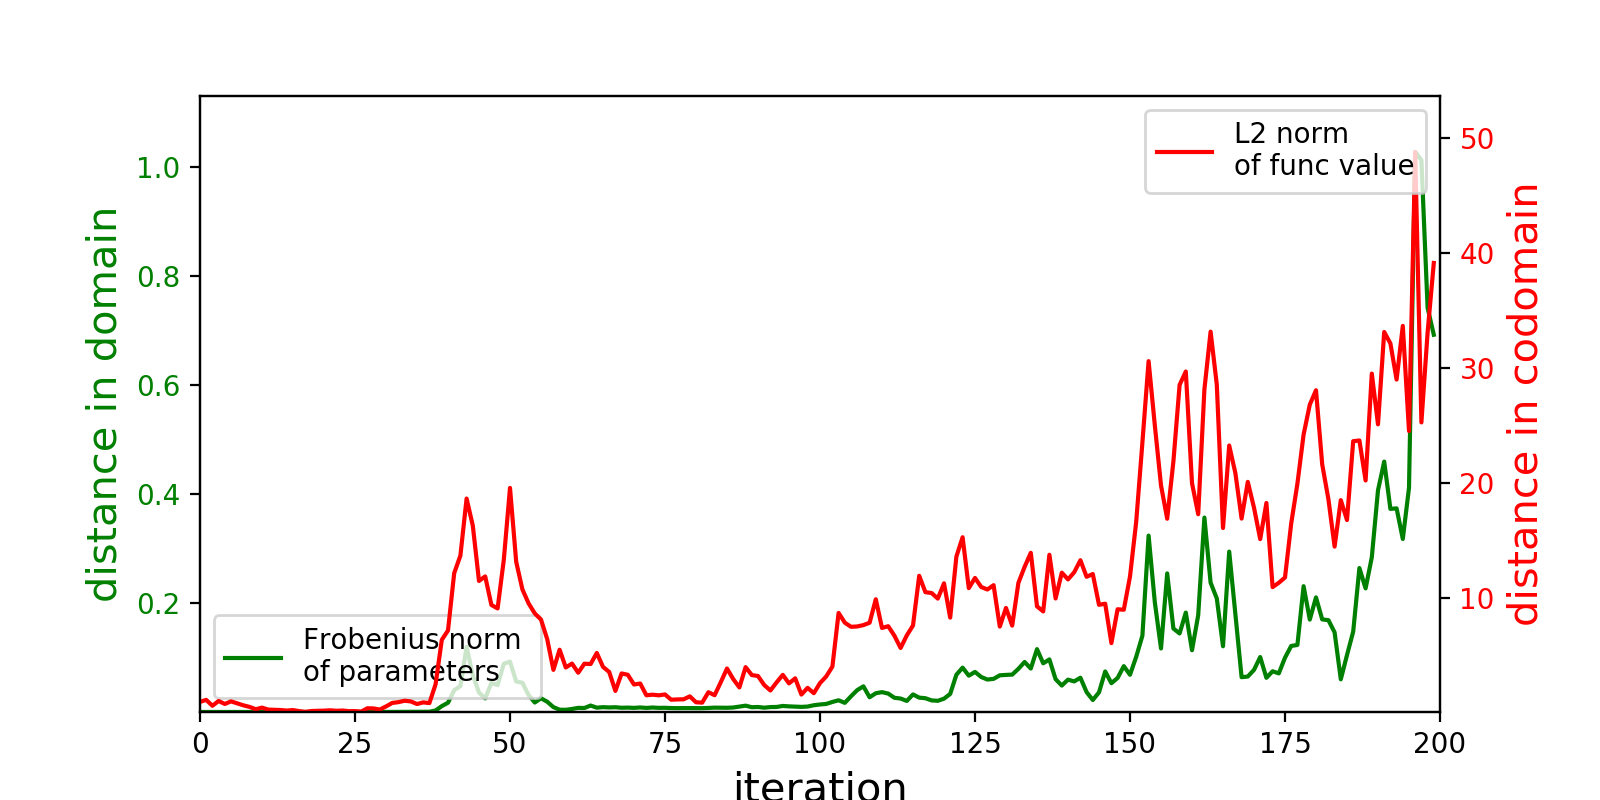

In [35]:
ex1.plot_distance()

<IPython.core.display.Javascript object>


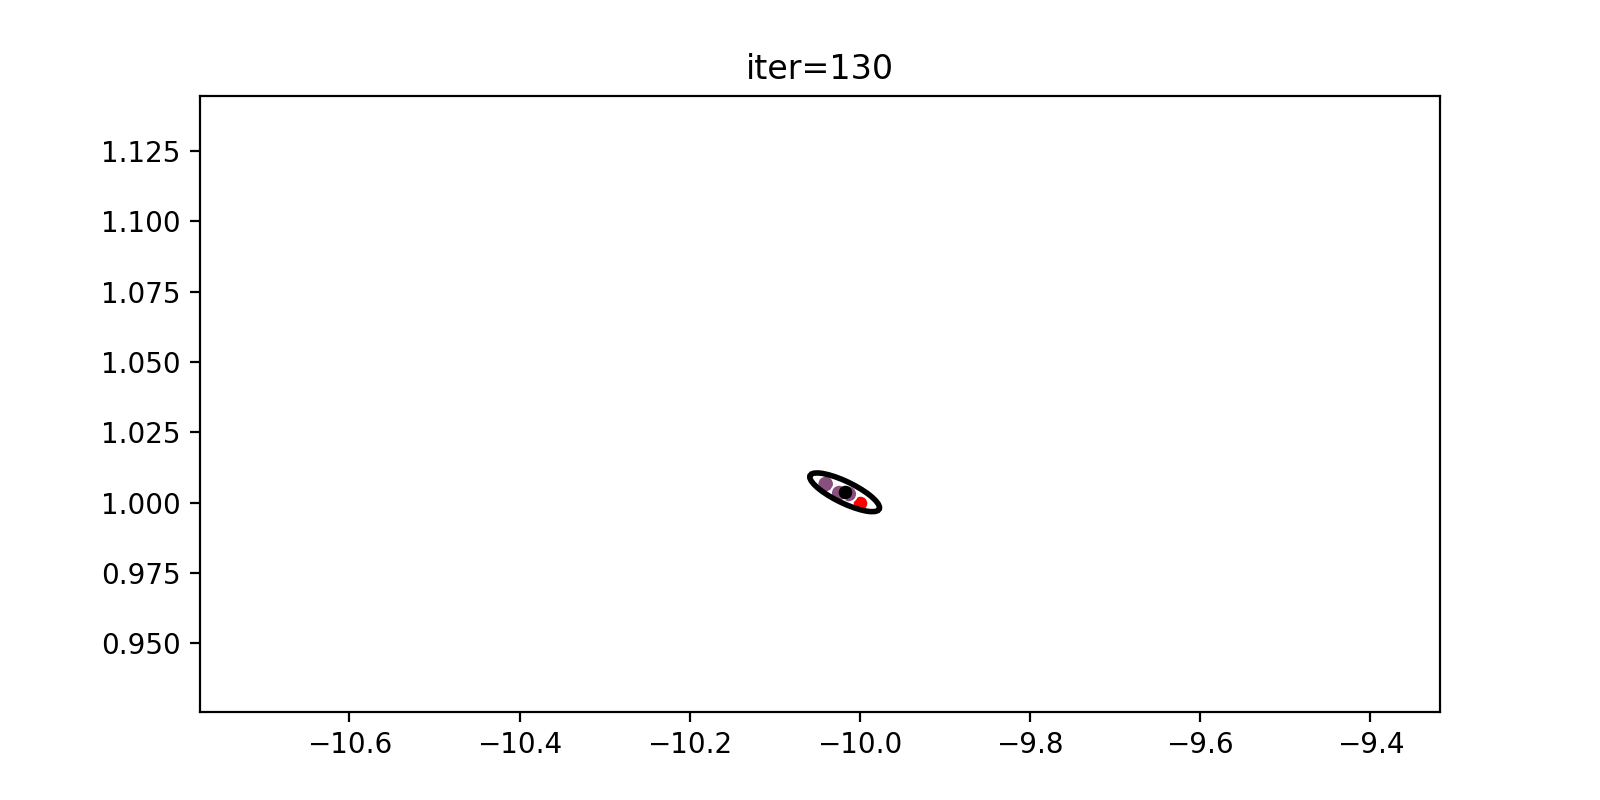

In [48]:
ex1.animate_moving_cluster()

<IPython.core.display.Javascript object>


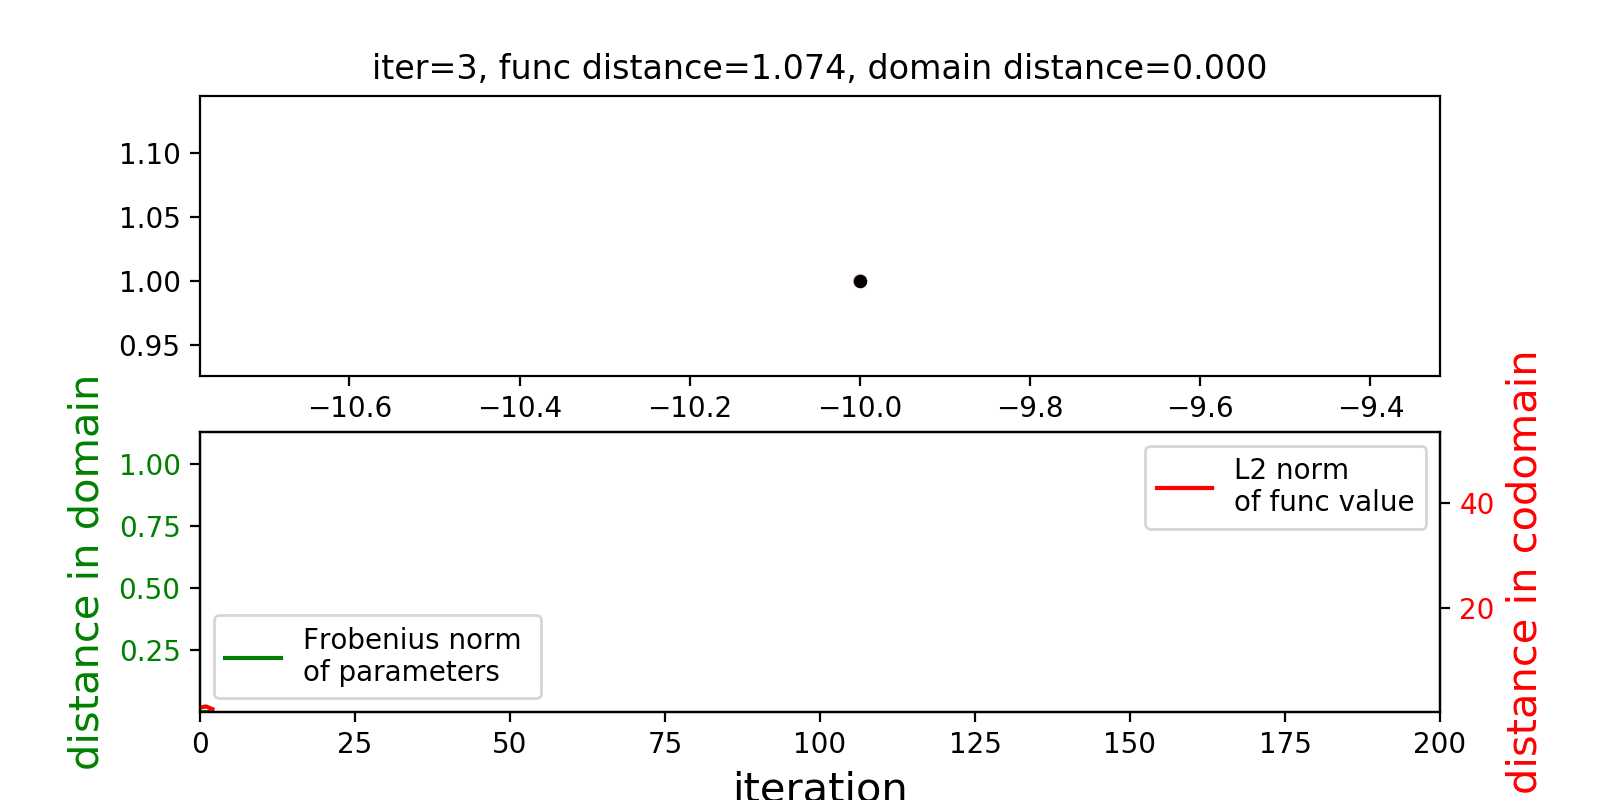

In [49]:
ex1.animate_scatterplot_distance()

In [54]:

ex1.generate_point_cloud(sigma, alpha, beta, do_nothing, 10, 50)

*******starting soon, intitial mean: ********
 [[39.920]
 [15.923]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 59.91448168374437, total iterations = 200, total evaluatios = 1200
 position = 37.957362741437564 14.35784961389038

*******starting soon, intitial mean: ********
 [[26.690]
 [18.340]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 80.7788195287738, total iterations = 200, total evaluatios = 1200
 position = 27.121502769863476 7.3518453437348565

*******starting soon, intitial mean: ********
 [[31.621]
 [9.309]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 38.64043444824128, total iterations = 200, total evaluatios = 1200
 position = 0.7116147920179756 -0.011372821837216128

*******starting soon, intitial mean: ********
 [[49.315]
 [42.951]]
diverge with LinAlgError!
*******starting soon, intitial mean: ********
 [[32.543]
 [5.626]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 1

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

invalid value encountered in less

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning:

invalid value encountered in less



stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 17.592210721932556, total iterations = 200, total evaluatios = 1200
 position = 4.917991007130406 0.2114404230718014

*******starting soon, intitial mean: ********
 [[47.573]
 [22.170]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 47.81822556361646, total iterations = 200, total evaluatios = 1200
 position = 3.05839055644232 0.17311732377644062

*******starting soon, intitial mean: ********
 [[37.055]
 [14.455]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 5.716405016753532, total iterations = 200, total evaluatios = 1200
 position = 14.298617149072491 2.0475003551430673

*******starting soon, intitial mean: ********
 [[18.579]
 [16.309]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 324.17615168834845, total iterations = 200, total evaluatios = 1200
 position = 26.725571534624628 6.4455821046102795



In [21]:
def setup_scattersss(ax, arg, stats, i):
    '''
    set up the plot of CMA-ES candidates at i-th iteration
    '''
    # draw x-axis and y-axis
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    # draw the position of optimal 
    ax.scatter(-10,1, c='red', s=15)
    # draw candidates on scatter plot
    ax.set_xlim(np.min(arg[:,:,0]), np.max(arg[:,:,0]))
    ax.set_ylim(np.min(arg[:,:,1]), np.max(arg[:,:,1]))
    p = sns.scatterplot(x=arg[i,:,0].ravel(), y=arg[i,:,1].ravel(), color="r", hue=i, hue_norm=(0, arg.shape[0]), legend=False)
    # draw ellipse representing 3 sigma areas of normal distribution
    draw_ellipse(ax, stats['mean'][i], stats['var'][i])



<IPython.core.display.Javascript object>


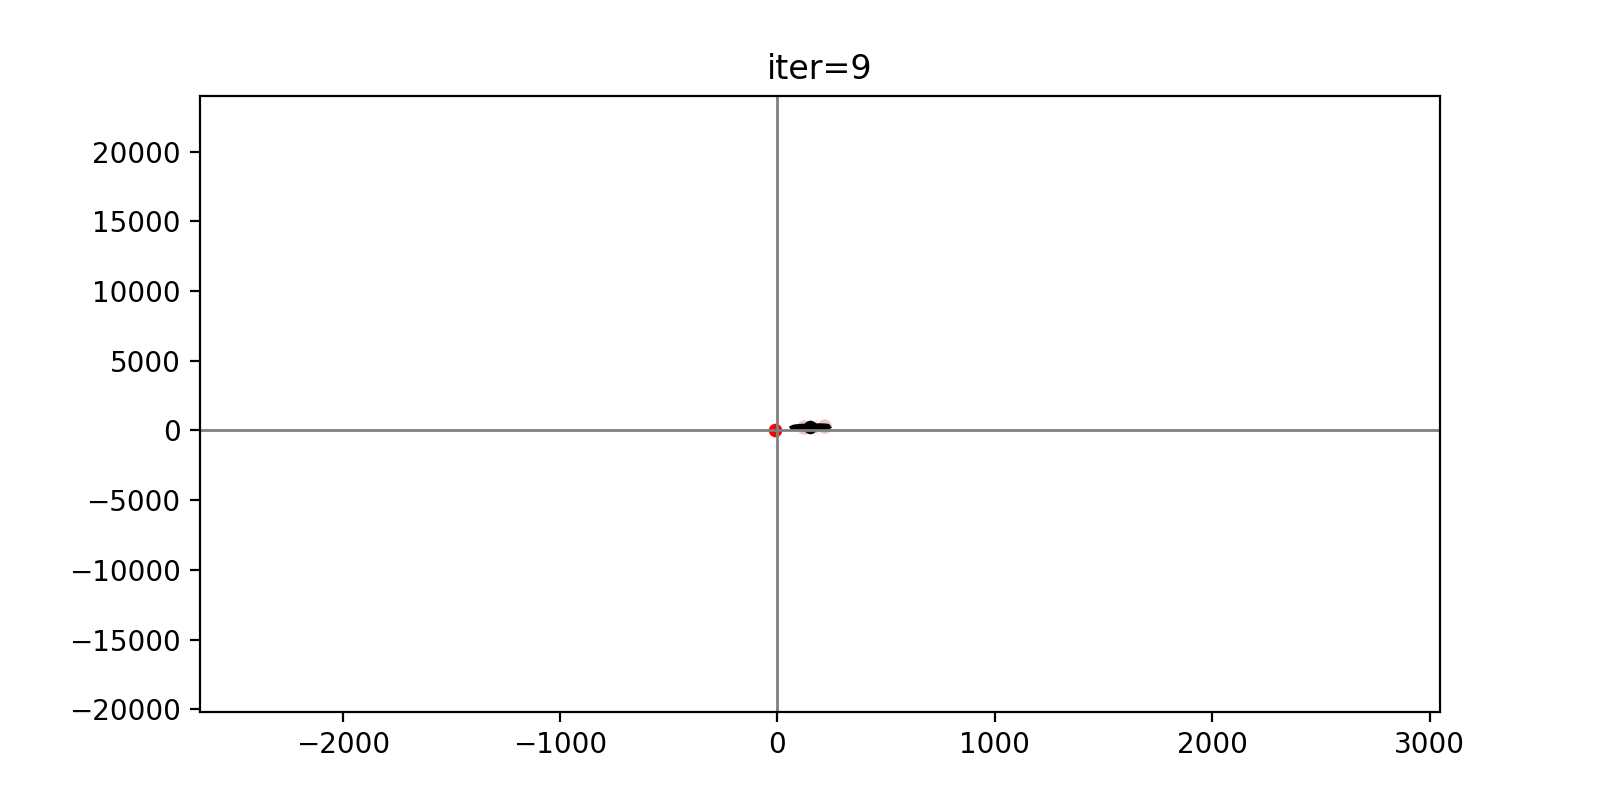

200


In [49]:

def animate(i):
    plt.clf()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('iter=%d' % (i+1))
    setup_scattersss(ax, arg, stats, i)
    
fig = plt.figure(figsize=(8,4))
ani = animation.FuncAnimation(fig, animate, frames=val.shape[0], repeat=True, interval=500)
print(val.shape[0]) 
plt.show()

In [ ]:
    plt.clf()
    ax = fig.add_subplot(1, 1, 1)
    mean = stats['mean'][i]
    eigVal_sqrt = eigVal_sqrts[i]
    eigVec = stats['var'][i] / eigVal_sqrt
    width, height = 2 * 3 * eigVal_sqrt
    angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
    e1 = patches.Ellipse(mean, width, height,
                         angle=-angle, linewidth=2, fill=False, zorder=2)
    ax.add_patch(e1)
    ax.scatter(mean[0], mean[1], c='black', s=15)
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)
    ax.set_xlim(np.min(x),  np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_title('iter=%d' % (i+1))
    #ax.grid(True)
    p = sns.scatterplot(x=x[int(i*num):int((i+1)*num)], y=y[int(i*num):int((i+1)*num)], 
                        color="r", hue=i, hue_norm=(0, arg.shape[0]), legend=False)

In [48]:
sys.stdout

In [28]:
def generate_point_cloudss(sigma, alpha, beta, adjust):
    def random_intial_mean(radius):
        rx = np.random.rand() * radius
        ry = np.random.rand() * radius 
        if(ry > rx):
            rx, ry = ry, rx
        return np.array([rx, ry])
    num = 50
    edge = 1000
    res = np.zeros((num, ))
    points = np.zeros((num, 2))
    result_strings = []
    exp = non_convex_optimisation(bukin, None, np.array([-10,1]), 0)
    for i in range(num):
        points[i] = random_intial_mean(edge)
        try:
            val, arg, stats = cma_es_general(points[i].reshape(2,1), sigma, alpha, beta, adjust, bukin, None)
        except np.linalg.LinAlgError as err:
            val, arg = None, None
            stats = {}
            stats['status'] = 'd'
            print('diverge with LinAlgError!')
        if(stats['status'] == 'd'):
            res[i] = 1
        elif(stats['status'] == 'l'):
            res[i] = 0.5
        else:
            res[i] = 0

In [29]:
np.random.seed(10)
generate_point_cloudss(sigma, alpha, beta, do_nothing)

*******starting soon, intitial mean: ********
 [[771.321]
 [20.752]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 110.35285257449759, total iterations = 200, total evaluatios = 1200
 position = 8.91113881568619 1.163339569120506

*******starting soon, intitial mean: ********
 [[127.697]
 [48.397]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 26.8191279366794, total iterations = 200, total evaluatios = 1200
 position = 6.284529235656276 0.3928813495658937

*******starting soon, intitial mean: ********
 [[726.219]
 [139.260]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 11.766844127515196, total iterations = 200, total evaluatios = 1200
 position = 1.423521653262076 0.00668580952982889

*******starting soon, intitial mean: ********
 [[994.047]
 [862.714]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 12.905084937335193, total iterations = 200, total evaluatios = 1200
 position = 9.411444751

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

invalid value encountered in less

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning:

invalid value encountered in less



stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 759.5739225963033, total iterations = 200, total evaluatios = 1200
 position = 75.63445922424609 66.19189417447684

*******starting soon, intitial mean: ********
 [[986.536]
 [926.477]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 1097.4103177878549, total iterations = 200, total evaluatios = 1200
 position = -369.09760439367335 1327.7145109538633

*******starting soon, intitial mean: ********
 [[409.618]
 [280.990]]
diverge with LinAlgError!
*******starting soon, intitial mean: ********
 [[741.708]
 [22.298]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 4.311458909871978, total iterations = 200, total evaluatios = 1200
 position = -1.7797368869862678 0.03346329473612344

*******starting soon, intitial mean: ********
 [[469.144]
 [189.505]]
stuck in local minimum!!
eigenvalue of variance = [0.000 0.000]
min = 2716.674838449985, total iterations = 200, total evaluatios